In [ ]:
# Base CNN Architecture: ResNet50V2
# Adapted from https://www.tensorflow.org/tutorials/images/classification

import os
CWD = os.getcwd()
print(CWD)
import shutil
import PIL
from PIL import Image

import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

## Set Training Dataset
### "ISIC-2017"
Models 1, 4
### "ISIC-2017 + DiDI_2022"
Models 2, 5
### "ISIC-2017 + ArGI_2024"
Model 3

In [2]:
# Code 
# TRAINING_SET = "ISIC_2017" 
#TRAINING_SET = "ISIC_2017 + DiDI_2022"
TRAINING_SET = "ISIC_2017 + ArGI_2024"

training_directory = f'{CWD}/datasets/{TRAINING_SET}'

## Set Train and Validation Datasets
### Tunable hyperparameters:
#### batch_size
    set size of batches put into the model.
    in case of OOM (out of memory) error, reduce this value
#### seed 
    changes randomization of dataset sampling. 
    Set to 123 for consistency across training.
#### validation_split
    changes percentage of data set aside for validation. 
    80-20 training-validation split employed for now, but can be changed.

In [ ]:
# Code
train_ds = trainset = keras.utils.image_dataset_from_directory(
    directory=training_directory,
    labels="inferred",
    batch_size=32, 
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="training",
    )

val_ds = keras.utils.image_dataset_from_directory(
    directory=training_directory,
    labels="inferred",
    batch_size=32, 
    image_size=(224,224),
    seed = 123,
    validation_split=0.2,
    subset="validation",
    )

In [ ]:
# Sanity Checks, ensuring our data was properly loaded
class_names = train_ds.class_names
print(class_names) # should return ['benign', 'malignant']

for image_batch, labels_batch in train_ds:
  print(image_batch.shape) # first value in this tuple should match
  print(labels_batch.shape) # the only value in this tuple
  break

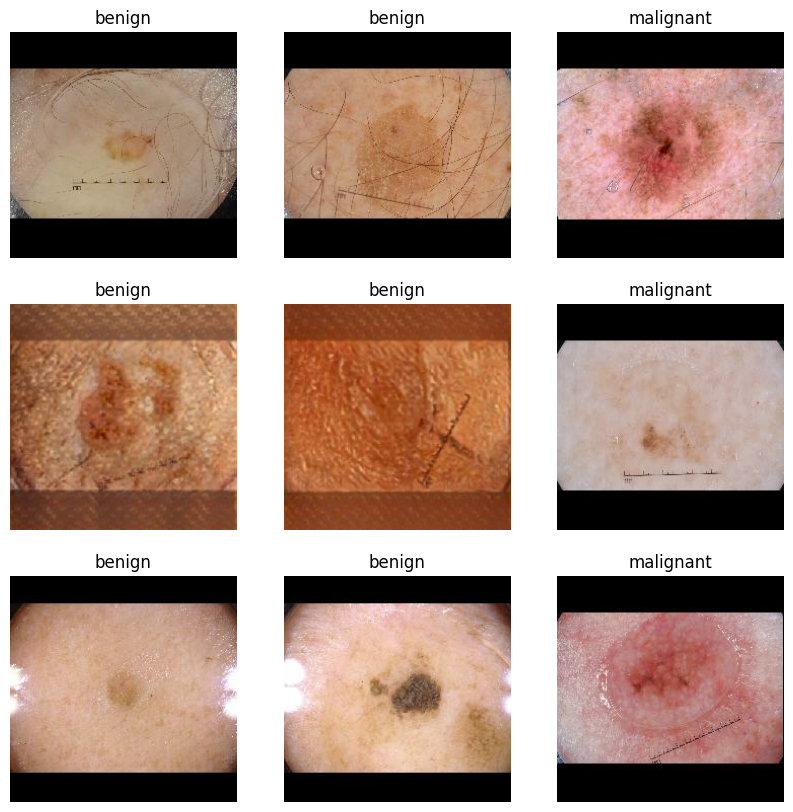

In [5]:
# Observing some images from our dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Efficiency preprocessing for datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Augment training dataset with random rotations
augment_rotation = tf.keras.layers.RandomRotation(
    factor = (0, 1), # allows for a full 2pi radians of rotations
    seed = 123 # defined for a little extra consistency
    ) 
train_ds = train_ds.map(lambda x, y: (augment_rotation(x),y))

In [7]:
# Load ResNet50V2 using Keras applications
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
core = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
# Train model
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [28]:
model = model # Get model (Sequential, Functional Model, or Model subclass)
model.save(f'{CWD}/models/ResNet50V2_{TRAINING_SET}.keras')  # The file needs to end with the .keras extension